# Original: https://github.com/benmoseley/harmonic-oscillator-pinn
### an mathematisches Pendel mit Dämpfung angepasst

# pendulum physics-informed neural network (PINN)


## Problem overview

The example problem we solve here is the 2D damped pendulum:
$$
\ddot \theta + \frac{\delta}{m \ell^2} \cdot \dot \theta + \frac{g}{\ell} \cdot \sin(\theta)  = 0~,
$$
with the initial conditions
$$
\theta(0) = 3.14~[rad]~~,~~\dot \theta(0) = 0~[\frac{rad}{s}]~.
$$
This has the following exact solution:
$$
???
$$

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.

## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash
conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```
```
conda install scipy
```

### Activate Enviroment in cmd
```bash
conda activate pinn
jupyter notebook 
```

In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import time

In [4]:
print(torch.cuda.is_available())

True


In [2]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [3]:
def pendulum(y, t, d, l):
    """Defines the analytical solution to the 2D damped pendulum problem.
    Equations taken from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html"""
    theta, omega = y
    return [omega, -d/(m*l**2)*omega - g/l*np.sin(theta)]

In [4]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generate training data

> First, we generate some training data from a small part of the true numerical solution.

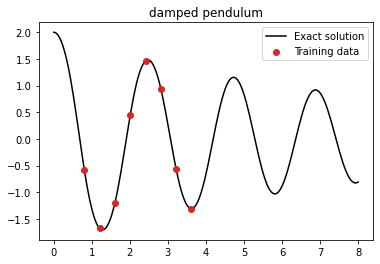

In [5]:
m = 1.0
l = 1.0
d = 0.2
g = 9.81

y0 = [2.0, 0.0] # Startwerte (theta [rad], omega [rad/s])

t1 = 8
frames = 200
t = np.linspace(0,t1,frames)

# DGL mit odeint numerisch lösen
solution = odeint(pendulum, y0, t, args=(d,l))
theta = solution[:,0]
omega = solution[:,1]

# Messpunkte aus Lösung generieren
# jeden 10. Messpunkt im Bereich [20-100]
t_data = t[20:100:10] 
theta_data = theta[20:100:10]

# theta über t
fig = plt.figure(111)
plt.title('damped pendulum')

plt.plot(t, theta, '-k', label="Exact solution")
plt.scatter(t_data, theta_data, color="tab:red", label="Training data", zorder=3)

plt.legend()
plt.show()

# np.array --> torch.Tensor 
theta = torch.Tensor(theta)
theta = theta.view(-1,1)
t = torch.Tensor(t).view(-1,1)

theta_data = torch.Tensor(theta_data).view(-1,1)
t_data = torch.Tensor(t_data).view(-1,1)

## Normal neural network

> Next, we train a standard neural network (fully connected) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [6]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    
    "Pretty plot training results"
    figure = plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    x_max = torch.max(x)
    y_min = torch.min(y)
    y_max = torch.max(y)
    plt.xlim(-0.1, x_max*1.1)
    plt.ylim(y_min*1.1, y_max*1.1)
    plt.text(x_max*1.1, y_max*0.75, "Training step: %i"%(i+1), fontsize="xx-large", color="k")
    plt.axis("off")
    
    return figure

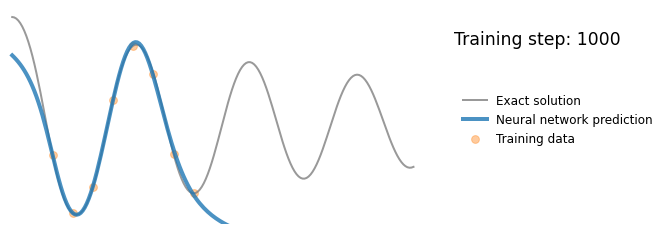

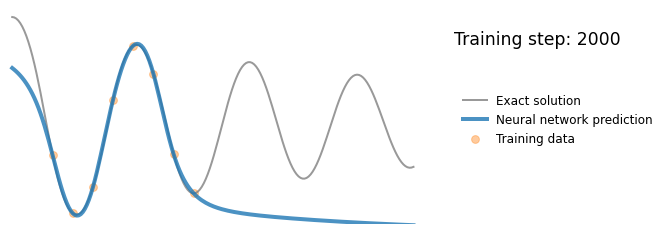

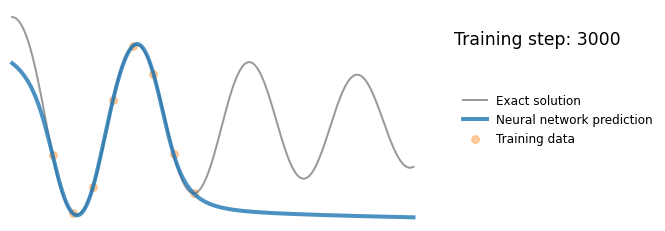

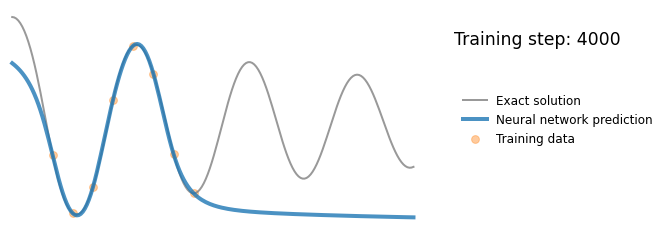

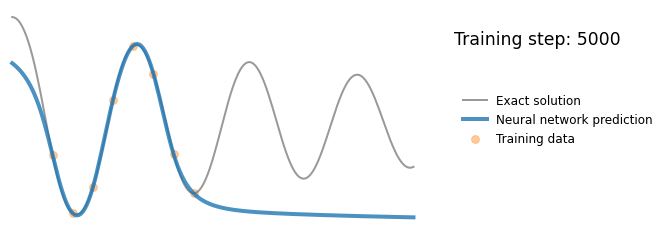

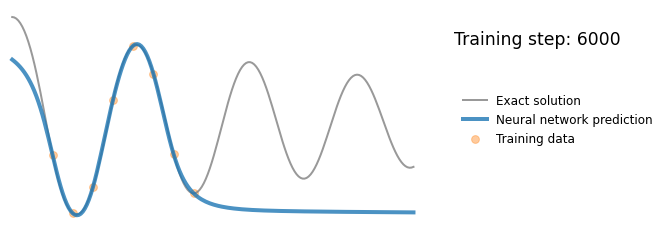

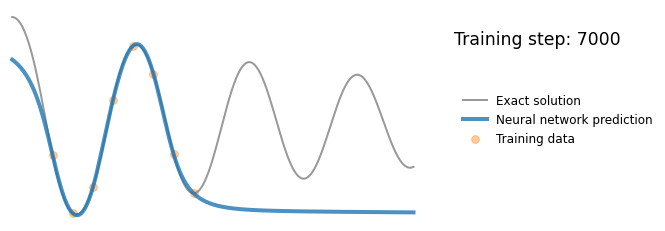

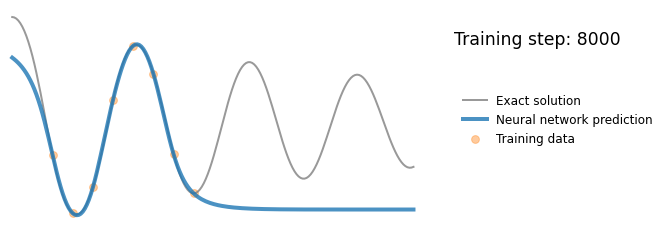

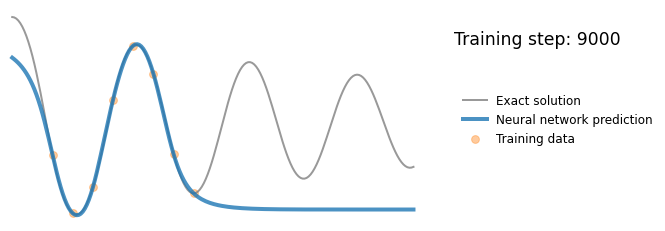

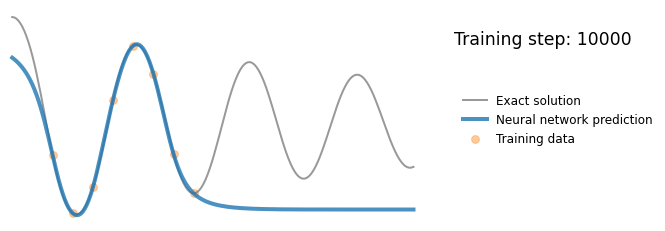

In [7]:
# train standard neural network to fit training data
torch.manual_seed(123) # Sets the seed for generating random numbers. Returns a torch.Generator object.
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(10000):
    
    optimizer.zero_grad()
    yh = model(t_data)
    loss = torch.mean((yh-theta_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 50 == 0: 
        
        yh = model(t).detach()
        
        fig = plot_result(t,theta,t_data,theta_data,yh)
        
        file = "plots/pendulum_nn_%.8i.png"%(i+1)
        fig.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 1000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pendulum_nn.gif", files, fps=20, loop=0)

## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain. We can calculate the derivatives of the network solution with respect to its input variable at these points using `pytorch`'s autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

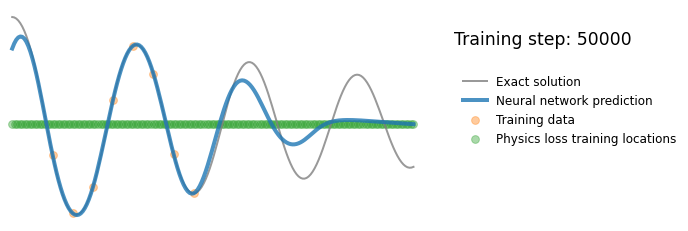

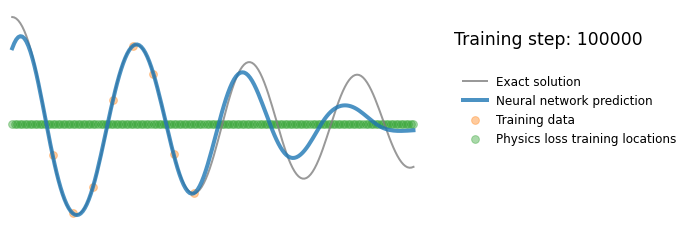

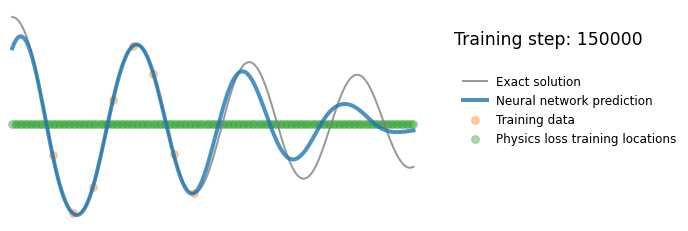

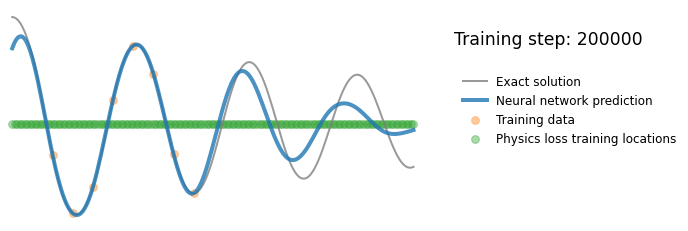

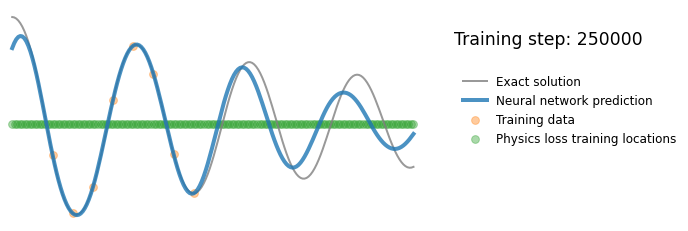

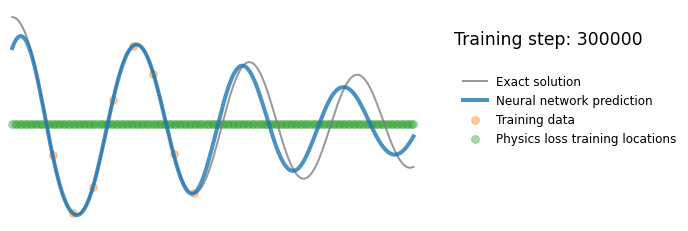

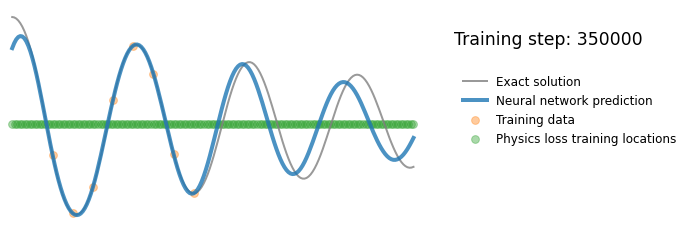

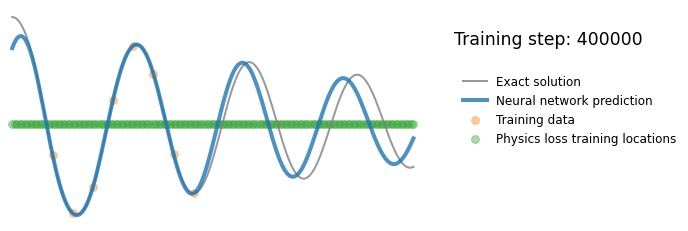

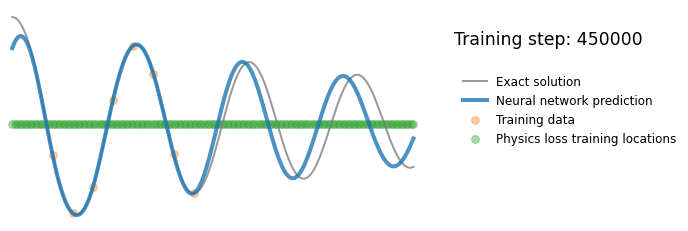

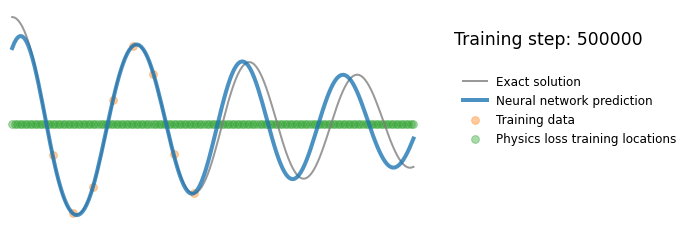

duration: 1068.1318531036377 [s]


In [8]:


x_physics = torch.linspace(0,t1,t1*20).view(-1,1).requires_grad_(True)# sample locations over the problem domain

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []

start = time.time()

for i in range(500000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(t_data)
    loss1 = torch.mean((yh-theta_data)**2)# use mean squared error
    
    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    #physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    physics = dx2 + (d/m*l**2)*dx + (g/l)*yhp
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2 # add two loss terms together
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % 2000 == 0: 
        
        yh = model(t).detach()
        xp = x_physics.detach()
        
        plot_result(t,theta,t_data,theta_data,yh,xp)
        
        file = "plots/pendulum_pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 50000 == 0: plt.show()
        else: plt.close("all")

duration = time.time() - start
print('duration: %s [s]' % duration)
            
save_gif_PIL("pendulum_pinn.gif", files, fps=20, loop=0)